In [161]:
import pandas as pd
import numpy as np
import scipy
import scipy.misc
from PIL import Image
import imageio as iio
from pathlib import Path
import string
import glob
import os
from sklearn.cluster import KMeans
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import itertools
import matplotlib as mpl
from scipy import linalg
from skimage.transform import resize
import skimage.transform as st
from alive_progress import alive_bar
import time
import numpy_indexed as npi
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [123]:
############
###Labels###
#age: from 1 to 116
#gender: 0-male; 1-female
#race: 0-white; 1-black; 2-Asian; 3-Indian; 4-others(like Hispanic, Latino, Middle Eastern)
############

labels = pd.read_csv('./data/labels.csv', header = None)
labels = labels.values
print(labels.shape)
print(labels)

(23705, 3)
[[100   0   0]
 [100   0   0]
 [100   1   0]
 ...
 [  9   1   4]
 [  9   1   4]
 [  9   1   4]]


In [3]:
print("labels of ages: {}".format(np.unique(labels[:, 0])))
print("labels of genders: {}".format(np.unique(labels[:, 1])))
print("labels of races: {}".format(np.unique(labels[:, -1])))

labels of ages: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 103 105 110 111 115 116]
labels of genders: [0 1]
labels of races: [0 1 2 3 4]


In [75]:
# read images from Faces folder
images = list()

filelist = glob.glob('./data/Faces/*.jpg')
for file in sorted(filelist, key=lambda s: int(s.strip(string.ascii_letters + "./"))):
    im = iio.imread(file)
    images.append(im)
images = np.array(images)
print(images.shape)

(23705, 200, 200, 3)


In [5]:
# resize all images from 200*200 to 160*160
im_resize = []
for i in range(images.shape[0]):
    imm_arr = np.array(Image.fromarray(images[i, :, :, :], 'RGB').resize((160, 160)))
    im_resize.append(imm_arr)
im_resize = np.array(im_resize)
print(im_resize.shape)

(23705, 160, 160, 3)


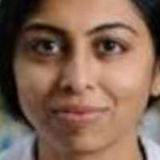

In [6]:
im_1 = im_resize[10001, :, :, :]
Image.fromarray(im_1, 'RGB')

In [7]:
workers = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [8]:
# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [9]:
dataset = np.einsum('klij->kjli', im_resize)
images_tensor = torch.tensor(dataset)
print(images_tensor.shape)
images_sel = images_tensor  # select all images or only a few images
print(images_sel.shape)

torch.Size([23705, 3, 160, 160])
torch.Size([23705, 3, 160, 160])


In [10]:
res = []
def compute():
    global res
    for i in range(images_sel.shape[0]):
        res.append(model(torch.unsqueeze(images_sel[i], 0).float()).detach().numpy())
        yield

In [11]:
with alive_bar(images_sel.shape[0], force_tty=True) as bar:
    for i in compute():
        # time.sleep(.005)
        bar()

|████████████████████████████████████████| 23705/23705 [100%] in 39:31.3 (10.00/s)                                      ▃▅▇ 5353/23705 [23%] in 9:01 (9.9/s, eta: 30:53) 


In [12]:
images_pro = np.squeeze(np.array(res))
print(images_pro.shape)

(23705, 512)


In [13]:
# PCA for dimension reduction
pca = PCA(n_components=120)
pca.fit(images_pro)

PCA(n_components=120)

In [14]:
images_pca = pca.transform(images_pro)
print(images_pca.shape)

(23705, 120)


In [15]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(images_pca)
kmeans_labels = kmeans.labels_

In [16]:
print(kmeans_labels)

[7 2 7 ... 7 6 4]


In [17]:
labels_sel = labels
stacked = np.hstack((labels_sel, kmeans_labels.reshape(np.size(kmeans_labels), 1)))
stacked_sorted = stacked[stacked[:, -1].argsort()]
print(stacked_sorted)

[[36  0  3  0]
 [26  0  2  0]
 [60  0  1  0]
 ...
 [36  0  0  9]
 [56  0  0  9]
 [58  0  1  9]]


In [18]:
def counter(cluster):
    
    # AGE
    # age groups: 1-20; 21-40; 41-60; 61-80; 81-100: >100
    age_counter = np.zeros(6)
    for i in range(cluster.shape[0]):
        if cluster[i, 0] >= 1 and cluster[i, 0] <= 20:
            age_counter[0] += 1
        elif cluster[i, 0] > 20 and cluster[i, 0] <= 40:
            age_counter[1] += 1
        elif cluster[i, 0] > 40 and cluster[i, 0] <= 60:
            age_counter[2] += 1
        elif cluster[i, 0] > 60 and cluster[i, 0] <= 80:
            age_counter[3] += 1
        elif cluster[i, 0] > 80 and cluster[i, 0] <= 100:
            age_counter[4] += 1
        else:
            age_counter[5] += 1
    # age_counter = age_counter / np.sum(counter)
    
    # GENDER
    gender_counter = np.zeros(2)
    for i in range(cluster.shape[0]):
        if cluster[i, 1] == 0:
            gender_counter[0] += 1
        else:
            gender_counter[1] += 1
    
    # RACE
    race_counter = np.zeros(5)
    for i in range(cluster.shape[0]):
        if cluster[i, 2] == 0:
            race_counter[0] += 1
        elif cluster[i, 2] == 1:
            race_counter[1] += 1
        elif cluster[i, 2] == 2:
            race_counter[2] += 1
        elif cluster[i, 2] == 3:
            race_counter[3] += 1
        else:
            race_counter[4] += 1
    
    return age_counter, gender_counter, race_counter

In [19]:
def cluster_division(stacked_labels, num_cluster):
    age_division = np.zeros((num_cluster, 6))
    gender_division = np.zeros((num_cluster, 2))
    race_division = np.zeros((num_cluster, 5))
    for i in range(num_cluster):
        cluster = stacked_labels[stacked_labels[:, -1] == i]
        age_counter, gender_counter, race_counter = counter(cluster)
        age_division[i, :] = age_counter
        gender_division[i, :] = gender_counter
        race_division[i, :] = race_counter
    return age_division, gender_division, race_division

In [20]:
np.set_printoptions(suppress=True)
age_division, gender_division, race_division = cluster_division(stacked_sorted, 10)
print('ROW - which cluster; COLUMN - which group of age/gender/race')
print('age division in different clusters: ')
print(age_division)
print('-------------------------------------------------------------------')
print('gender division in different clusters: ')
print(gender_division)
print('-------------------------------------------------------------------')
print('race division in different clusters: ')
print(race_division)

ROW - which cluster; COLUMN - which group of age/gender/race
age division in different clusters: 
[[ 470. 1405.  383.  126.   21.    0.]
 [ 657. 1108.  360.  153.   55.    1.]
 [ 394.  807.  409.  198.   87.    8.]
 [ 186. 1107.  235.   61.   17.    2.]
 [1278. 1049.  434.  184.   37.    0.]
 [ 225. 1001.  212.   63.   15.    0.]
 [ 217.  622.   92.   23.    7.    0.]
 [ 733. 1901.  994.  473.  140.    6.]
 [ 193.  806.  596.  368.   88.    3.]
 [ 524. 2316.  596.  206.   52.    1.]]
-------------------------------------------------------------------
gender division in different clusters: 
[[1167. 1238.]
 [1348.  986.]
 [1175.  728.]
 [ 732.  876.]
 [1442. 1540.]
 [ 874.  642.]
 [ 392.  569.]
 [2330. 1917.]
 [1418.  636.]
 [1513. 2182.]]
-------------------------------------------------------------------
race division in different clusters: 
[[ 772.  628.  322.  464.  219.]
 [ 795.  704.  309.  348.  178.]
 [ 869.  399.  233.  303.   99.]
 [ 573.  334.  239.  317.  145.]
 [1294.  375. 

In [21]:
# sort1 = stacked_sorted[np.logical_and(stacked_sorted[:, 0] >= 21, stacked_sorted[:, 0] <= 40)]
# sort2 = sort1[np.logical_and(sort1[:, 1] == 0, sort1[:, 2] == 0)]
# sort3 = sort2[sort2[:, -1] == 0]
# print(sort3.shape)

In [40]:
indices = []
for i in range(10):
    indices.append(np.argwhere(stacked[:, -1] == i).T)

In [44]:
# im_resize[im_resize[0, :, :, :] in indices[0]]
cluster_0 = np.squeeze(indices[0], axis = 0)
np.random.shuffle(cluster_0)

In [45]:
cluster_0

array([12555, 17994,  2186, ...,  5965, 16723,  8850])

In [48]:
cl0 = cluster_0[0:10]
for i in range(10):
    im = im_resize[cl0[i], :, :, :]
    imm = Image.fromarray(im, 'RGB')
    imm.show()

In [49]:
cluster_1 = np.squeeze(indices[1], axis = 0)
np.random.shuffle(cluster_1)

In [50]:
cl1 = cluster_1[0:10]
for i in range(10):
    im = im_resize[cl1[i], :, :, :]
    imm = Image.fromarray(im, 'RGB')
    imm.show()

In [52]:
# save the forwarded data into a csv file
# np.savetxt('ForwardedImages.csv', images_pro, delimiter=",") 

# Import the saved csv

In [6]:
df = pd.read_csv('ForwardedImages.csv', header=None) 

In [7]:
dataset = df.values

In [8]:
dataset.shape

(23705, 512)

# Split the training set and test set - without landmarks

In [51]:
indices = np.arange(dataset.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(dataset, labels[:, 1], 
                                                                         indices, test_size=0.1, random_state=42)

In [58]:
print('The number of training samples and indices: ')
print(np.size(idx_train))
print(idx_train)
print('------------------------------------------------')
print('The number of test samples and indices: ')
print(np.size(idx_test))
print(idx_test)

The number of training samples and indices: 
21334
[10325   776 10087 ...   860 15795 23654]
------------------------------------------------
The number of test samples and indices: 
2371
[17814 15080 22829 ... 13829 16543  4484]


## Perform SVM to classify gender

In [59]:
# fit the training set with Support Vector Machine classifier
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [60]:
y_svm = clf.predict(X_test)

In [61]:
print(y_svm)
print(np.size(y_svm))
print(y_test)
print(np.size(y_test))

[1 1 0 ... 0 0 1]
2371
[1 0 1 ... 0 0 1]
2371


### the accuracy for classifying the gender

In [112]:
correct = 0
idx_correct = []
idx_incorrect = []
for i in range(np.size(y_test)):
    if y_test[i] == y_svm[i]:
        correct += 1
        idx_correct.append(i)
    else:
        idx_incorrect.append(i)
print(correct / np.size(y_test))

0.7199493884436946


In [113]:
idx_test_correct = idx_test[idx_correct]
idx_test_incorrect = idx_test[idx_incorrect]
print(np.size(idx_test_correct))
print(np.size(idx_test_incorrect))
print(idx_test_correct)
print('-------------------------------------------------')
print(idx_test_incorrect)

1707
664
[17814 16074  8972 ... 13829 16543  4484]
-------------------------------------------------
[15080 22829 19252 14324 21041  6292 14378 11816 10236 10018 23554 15248
  9054 13556 14063  5576  6515  1190 15075  5841  8278 21370 23494 23057
  3780 15949 21351 19677 16568 10870  6029  2173 20016   199  2790 21018
  5163 19137 13953   516 11406  3125  2252  5047  9233 20338 21581 19652
 14328 21649 22869 10772 23255  5658 11048 21321 15107 23512  5598  1684
 23176 16171  7216 12073 23157 14801  4097  5610  1475  1603  4596 10384
   635  1765  3070 12215 10500  2789 13868 15009  1527 22458 12030  5826
 21265 22917 21405  4059  1710 12656 17974 10201 16083  4505  2111   280
  5384  2622 17411 15692 10317  2715   469 11201  2145 23466 23490 22975
 21261 15220 12322 22363  8220   501 14499  6826 19416  3068  1644  1052
 23113 23015  9586 23506  6779    52 21255 19431 11024  8960  9876  2201
  5500 21092  8336  5635 23630 14354 22786  1713  4720  2342    29 15056
 22132 13655 10722 2063

### Plot examples with correct genders

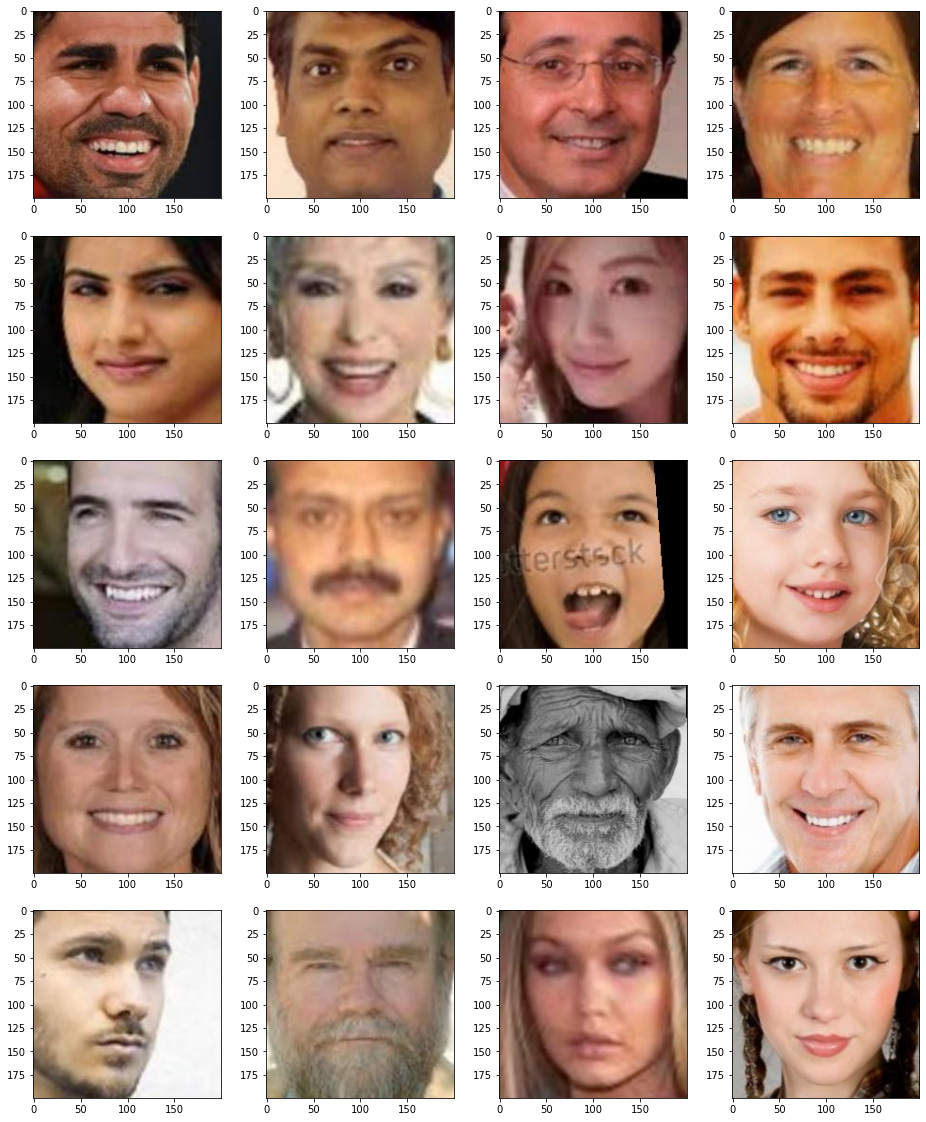

In [114]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = images[idx_test_correct[i], :, :, :]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Plot examples with incorrect genders

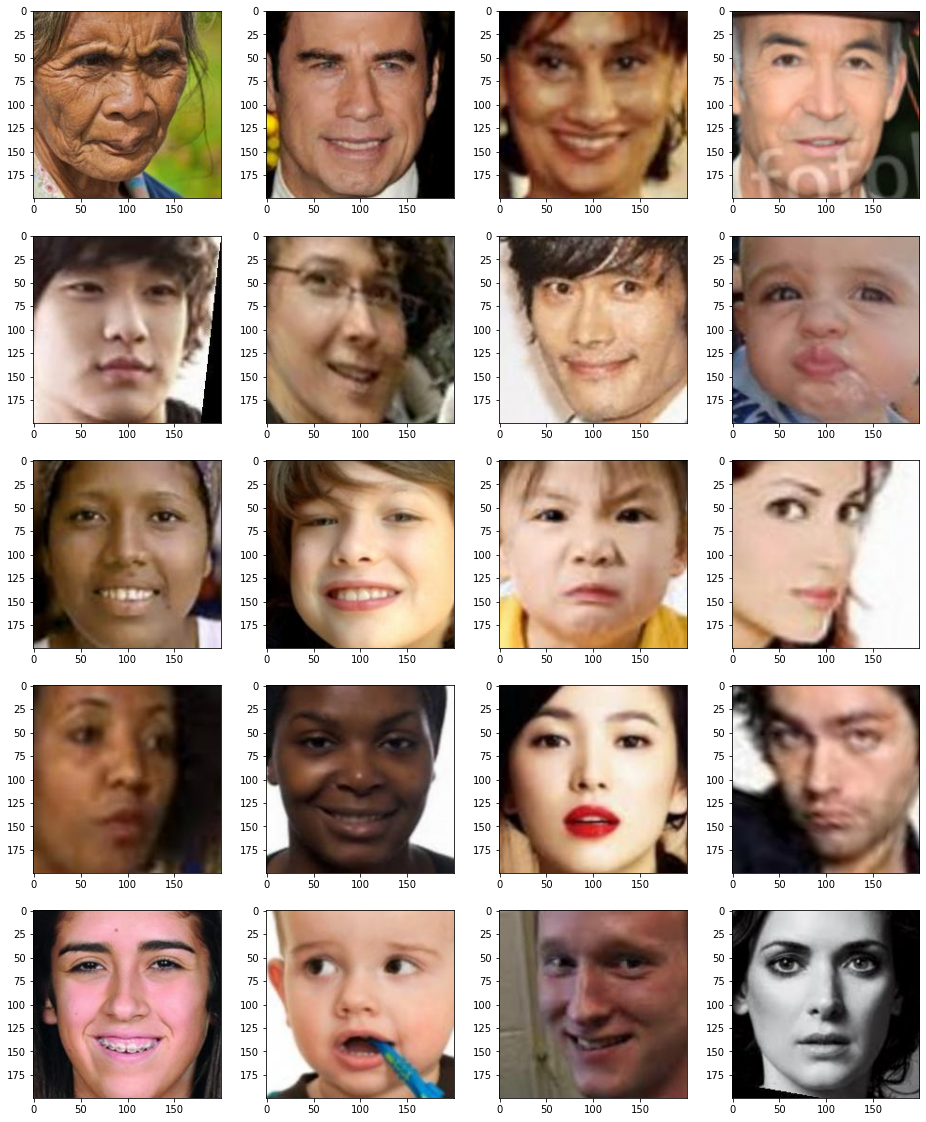

In [115]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = images[idx_test_incorrect[i], :, :, :]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [116]:
print('the number of male images in the test-set: {}'.format(np.size(y_test) - np.count_nonzero(y_test)))
print('Percentage of male images: {}'.format((np.size(y_test) - np.count_nonzero(y_test)) / np.size(y_test)))
print('the number of female images in the test-set: {}'.format(np.count_nonzero(y_test)))
print('percentage of female images: {}'.format(np.count_nonzero(y_test) / np.size(y_test)))

the number of male images in the test-set: 1215
Percentage of male images: 0.5124420075917334
the number of female images in the test-set: 1156
percentage of female images: 0.4875579924082665


In [117]:
def age_division(idxArray):
    # AGE
    # age groups: 1-10; 11-20; 21-30; 31-40; 41-50; ... ; >100
    age_counter = np.zeros(11)
    for i in range(np.size(idxArray)):
        if labels[idxArray[i], 0] >= 1 and labels[idxArray[i], 0] <= 10:
            age_counter[0] += 1
        elif labels[idxArray[i], 0] >10 and labels[idxArray[i], 0] <= 20:
            age_counter[1] += 1
        elif labels[idxArray[i], 0] >20 and labels[idxArray[i], 0] <= 30:
            age_counter[2] += 1
        elif labels[idxArray[i], 0] >30 and labels[idxArray[i], 0] <= 40:
            age_counter[3] += 1
        elif labels[idxArray[i], 0] >40 and labels[idxArray[i], 0] <= 50:
            age_counter[4] += 1
        elif labels[idxArray[i], 0] >50 and labels[idxArray[i], 0] <= 60:
            age_counter[5] += 1
        elif labels[idxArray[i], 0] >60 and labels[idxArray[i], 0] <= 70:
            age_counter[6] += 1
        elif labels[idxArray[i], 0] >70 and labels[idxArray[i], 0] <= 80:
            age_counter[7] += 1
        elif labels[idxArray[i], 0] >80 and labels[idxArray[i], 0] <= 90:
            age_counter[8] += 1
        elif labels[idxArray[i], 0] >90 and labels[idxArray[i], 0] <= 100:
            age_counter[9] += 1
        else:
            age_counter[10] += 1
    return age_counter

In [126]:
age_test_correct = age_division(idx_test_correct)
print(age_test_correct)
age_test_incorrect = age_division(idx_test_incorrect)
print(age_test_incorrect)
age_test = age_division(idx_test).astype(int)
print(age_test)

age_correct_p = np.round(age_test_correct / age_test, 3) * 100
age_incorrect_p = np.round(age_test_incorrect / age_test, 3) * 100
print(age_correct_p)
print(age_incorrect_p)

[175. 107. 597. 332. 169. 163.  90.  51.  20.   2.   1.]
[129.  55. 218. 101.  34.  44.  36.  14.  25.   8.   0.]
[304 162 815 433 203 207 126  65  45  10   1]
[ 57.6  66.   73.3  76.7  83.3  78.7  71.4  78.5  44.4  20.  100. ]
[42.4 34.  26.7 23.3 16.7 21.3 28.6 21.5 55.6 80.   0. ]


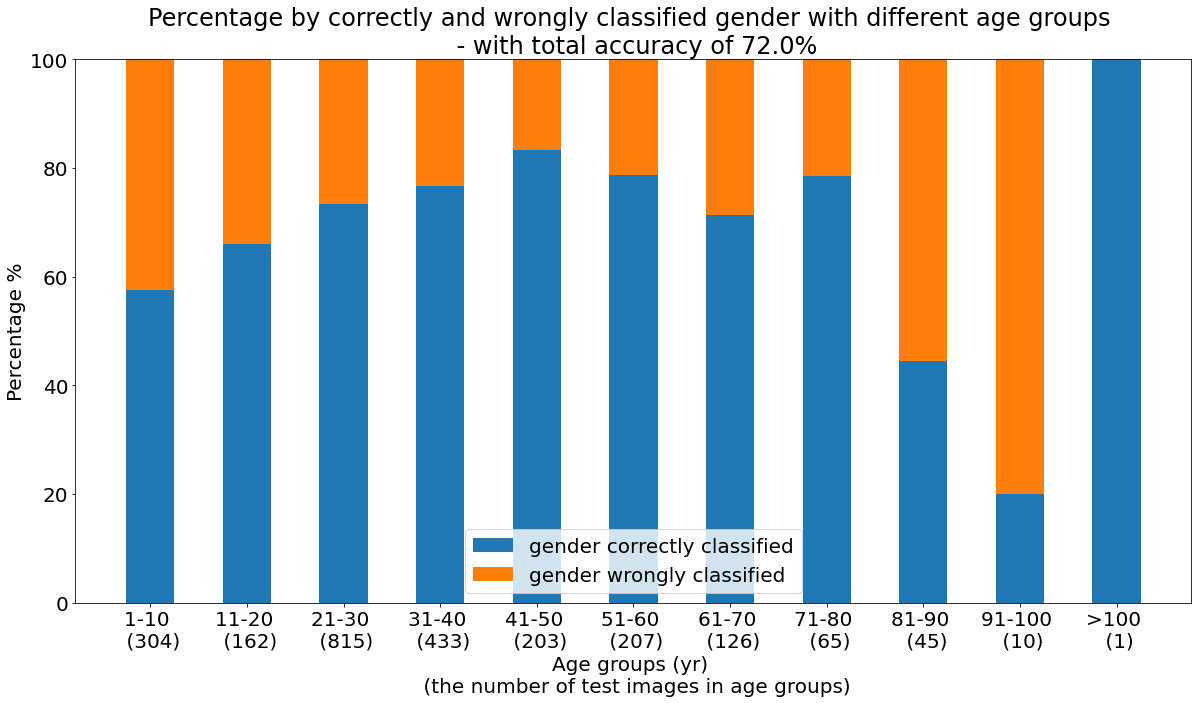

In [142]:
ax_labels = ['1-10 \n ({})'.format(age_test[0]), 
             '11-20 \n ({})'.format(age_test[1]), 
             '21-30 \n ({})'.format(age_test[2]), 
             '31-40 \n ({})'.format(age_test[3]), 
             '41-50 \n ({})'.format(age_test[4]), 
             '51-60 \n ({})'.format(age_test[5]), 
             '61-70 \n ({})'.format(age_test[6]), 
             '71-80 \n ({})'.format(age_test[7]), 
             '81-90 \n ({})'.format(age_test[8]), 
             '91-100 \n ({})'.format(age_test[9]), 
             '>100 \n ({})'.format(age_test[10])]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(ax_labels, age_correct_p, width, label='gender correctly classified')
ax.bar(ax_labels, age_incorrect_p, width, bottom=age_correct_p, label='gender wrongly classified')

plt.rcParams.update({'font.size': 20})
ax.set_xlabel('Age groups (yr) \n (the number of test images in age groups)')
ax.set_ylabel('Percentage %')
ax.set_title('Percentage by correctly and wrongly classified gender with different age groups \n - with total accuracy of {}%'
             .format(np.round(correct / np.size(y_test), 3) * 100))
ax.legend()

plt.show()

In [151]:
def race_division(idxArray):
    race_counter = np.zeros(5)
    for i in range(np.size(idxArray)):
        if labels[idxArray[i], 2] == 0:
            race_counter[0] += 1
        elif labels[idxArray[i], 2] == 1:
            race_counter[1] += 1
        elif labels[idxArray[i], 2] == 2:
            race_counter[2] += 1
        elif labels[idxArray[i], 2] == 3:
            race_counter[3] += 1
        else:
            race_counter[4] += 1
    return race_counter

In [152]:
race_test_correct = race_division(idx_test_correct)
print(race_test_correct)
race_test_incorrect = race_division(idx_test_incorrect)
print(race_test_incorrect)
race_test = race_division(idx_test).astype(int)
print(race_test)

race_correct_p = np.round(race_test_correct / race_test, 3) * 100
race_incorrect_p = np.round(race_test_incorrect / race_test, 3) * 100
print(race_correct_p)
print(race_incorrect_p)

[709. 275. 263. 322. 138.]
[275. 145.  86. 108.  50.]
[984 420 349 430 188]
[72.1 65.5 75.4 74.9 73.4]
[27.9 34.5 24.6 25.1 26.6]


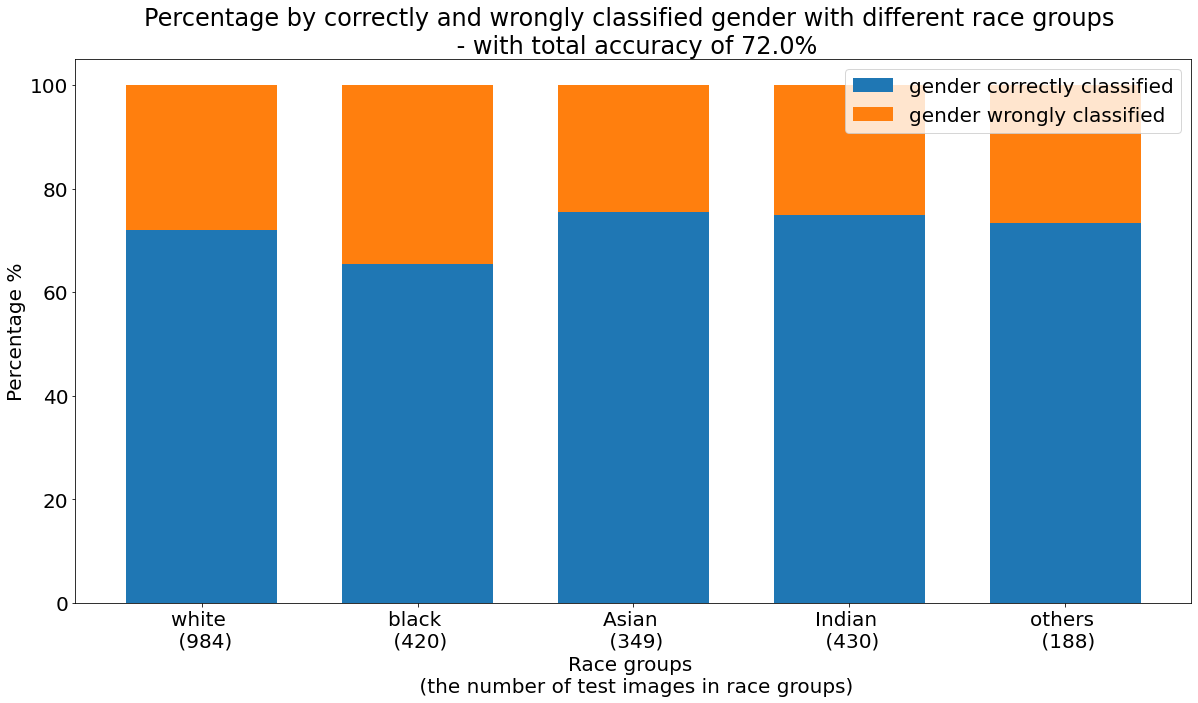

In [154]:
#race: 0-white; 1-black; 2-Asian; 3-Indian; 4-others(like Hispanic, Latino, Middle Eastern)
ax_labels = ['white \n ({})'.format(race_test[0]), 
             'black \n ({})'.format(race_test[1]), 
             'Asian \n ({})'.format(race_test[2]), 
             'Indian \n ({})'.format(race_test[3]), 
             'others \n ({})'.format(race_test[4])]
width = 0.7       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(ax_labels, race_correct_p, width, label='gender correctly classified')
ax.bar(ax_labels, race_incorrect_p, width, bottom=race_correct_p, label='gender wrongly classified')

plt.rcParams.update({'font.size': 20})
ax.set_xlabel('Race groups \n (the number of test images in race groups)')
ax.set_ylabel('Percentage %')
ax.set_title('Percentage by correctly and wrongly classified gender with different race groups \n - with total accuracy of {}%'
             .format(np.round(correct / np.size(y_test), 3) * 100))
ax.legend()

plt.show()

## Perform SVM to classify the race

In [156]:
indices = np.arange(dataset.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(dataset, labels[:, 2], 
                                                                         indices, test_size=0.1, random_state=42)

In [162]:
# fit the training set with Support Vector Machine classifier
clf = OneVsRestClassifier(svm.SVC())
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [163]:
y_svm = clf.predict(X_test)
print(np.unique(y_svm))

[0 1 2 3 4]


### the accuracy to classify the race

In [165]:
correct = 0
idx_correct = []
idx_incorrect = []
for i in range(np.size(y_test)):
    if y_test[i] == y_svm[i]:
        correct += 1
        idx_correct.append(i)
    else:
        idx_incorrect.append(i)
print(correct / np.size(y_test))

0.5044285111767187


In [166]:
idx_test_correct = idx_test[idx_correct]
idx_test_incorrect = idx_test[idx_incorrect]
print(np.size(idx_test_correct))
print(np.size(idx_test_incorrect))
print(idx_test_correct)
print('-------------------------------------------------')
print(idx_test_incorrect)

1196
1175
[15080 19252 19246 ... 13829 16543  4484]
-------------------------------------------------
[17814 22829 16074 ...  6580  1443 14957]


In [180]:
race_correct = race_division(idx_test_correct)
race_incorrect = race_division(idx_test_incorrect)
race_total = race_division(idx_test).astype(int)
print(race_correct)
print(race_incorrect)
print(race_total)

[838. 264.  61.  31.   2.]
[146. 156. 288. 399. 186.]
[984 420 349 430 188]


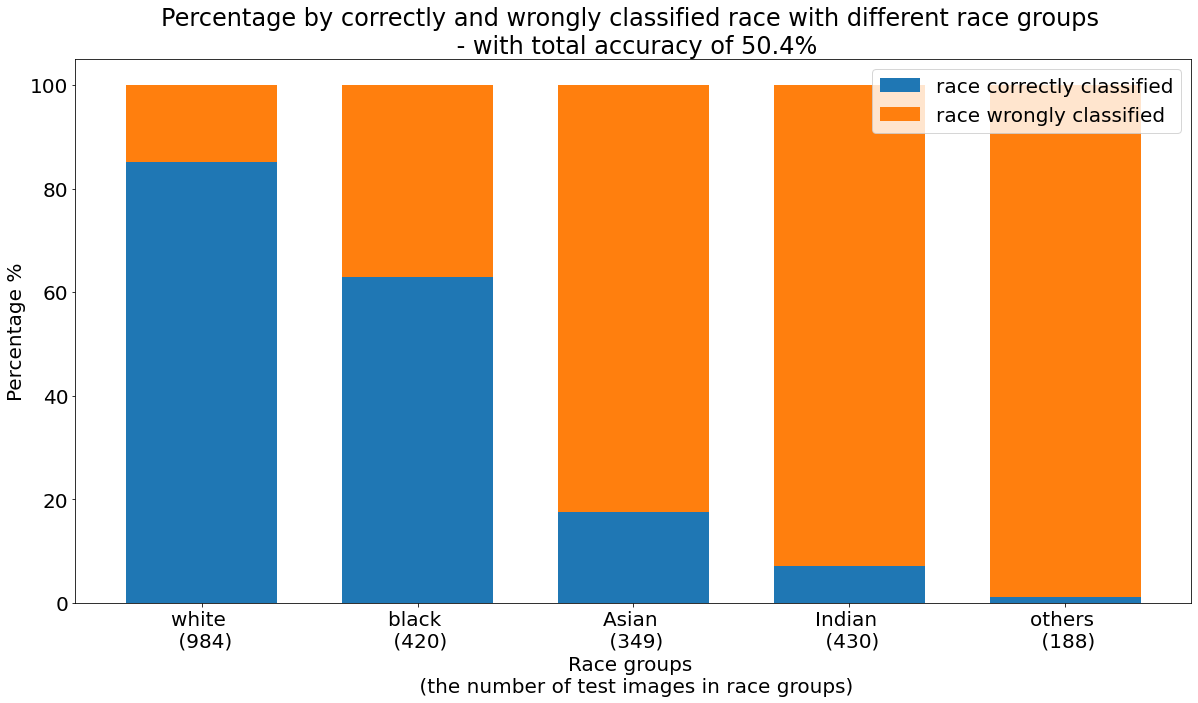

In [182]:
#race: 0-white; 1-black; 2-Asian; 3-Indian; 4-others(like Hispanic, Latino, Middle Eastern)
ax_labels = ['white \n ({})'.format(race_total[0]), 
             'black \n ({})'.format(race_total[1]), 
             'Asian \n ({})'.format(race_total[2]), 
             'Indian \n ({})'.format(race_total[3]), 
             'others \n ({})'.format(race_total[4])]
width = 0.7       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(ax_labels, np.round(race_correct / race_total, 3)*100, width, label='race correctly classified')
ax.bar(ax_labels, np.round(race_incorrect / race_total, 3)*100, width, bottom=np.round(race_correct / race_total, 3)*100, label='race wrongly classified')

plt.rcParams.update({'font.size': 20})
ax.set_xlabel('Race groups \n (the number of test images in race groups)')
ax.set_ylabel('Percentage %')
ax.set_title('Percentage by correctly and wrongly classified race with different race groups \n - with total accuracy of {}%'
             .format(np.round(correct / np.size(y_test), 3) * 100))
ax.legend()

plt.show()

984
